In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

%matplotlib inline

### Подготовка данных

#### Чистим данные

In [3]:
df = pd.read_excel('for_clustering.xlsx')

In [4]:
print(df.shape)
df.head()

(27508, 45)


,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Age_group,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,1,12,3,1295.44,22,10.360064,F,37.0,35-45,11,3,175,2747.71,0.221616,278,3490.27,0.281507,420,4096.35,0.330391,161,1059.810,0.085479,80,1004.370,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,1,10,2,1835.23,17,12.088369,F,29.0,25-35,11,2,199,4097.59,0.316181,279,4027.09,0.310741,407,3303.69,0.254921,93,1054.805,0.081391,46,476.475,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,1,6,4,586.79,7,15.591491,F,33.0,25-35,29,8,18,121.36,0.040946,62,2013.35,0.679295,39,159.50,0.053815,34,334.830,0.112970,17,334.840,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,1,12,1,1374.17,36,7.703276,F,50.0,45-55,11,0,798,5176.77,0.263096,500,5094.25,0.258902,995,7777.19,0.395256,129,1088.880,0.055340,64,539.250,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,1,5,4,1469.43,11,9.278015,F,33.0,25-35,14,8,59,639.32,0.257558,73,807.58,0.325343,90,264.95,0.106738,22,664.180,0.267573,11,106.210,0.042788,1,1,22,3,557.97,1,1,1,1


In [5]:
df.columns

Index(['Id_client', 'InWeek_amount', 'InWeek_SKU', 'Checkinmonth_average',
       'Checkamount_mean', 'Count_transac', 'Total_amount', 'Total_SKU_qnt',
       'Count_departments', 'Count_shop', 'Count_city', 'Tenure',
       'SKU_meanbytransac', 'Amount_last6mnth', 'Check_qntlast6mnth',
       'SKU_price_mean', 'Gender', 'Age', 'Age_group', 'Interval_visit',
       'Days_pastvisit', 'Cat_householdchem_qnt', 'Cat_householdchem_amount',
       'Cat_householdchem_share', 'Cat_careproducts_qnt',
       'Cat_careproducts_amount', 'Cat_careproducts_share',
       'Cat_toiletries_qnt', 'Cat_toiletries_amount', 'Cat_toiletries_share',
       'Cat_healthwellnes_qnt', 'Cat_healthwellnes_amount',
       'Cat_healthwellnes_share', 'Cat_babyprod_qnt', 'Cat_babyprod_amount',
       'Cat_babyprod_share', 'Communication_3month', 'Response_communcation',
       'SKU_LastMonthqnt', 'Checks_LastMonthqnt', 'Amount_LastMonth',
       'Discount', 'Discount_LastMonth', '_SEGMENT_', 'EM_SEGMENT'],
      dtype

Избавляемся от строк с отсутствующими данными.

Удаляем дублирующиеся строки.

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
print(df.shape)

(27267, 46)


Ищем колонки, которые нельзя привести к числовому виду

In [7]:
no_num_cols = []
for column in df.columns:
    isnum = pd.to_numeric(df[column][~df[column].isna()], errors='coerce').notnull().all()
    if not isnum:
        no_num_cols.append(column)
        
df[no_num_cols].head()

,Gender,Age_group
0,F,35-45
1,F,25-35
2,F,25-35
3,F,45-55
4,F,25-35


Колонку 'Gender' преобразуем в числа, а 'Age_group' просто удаляем.

Это можно делать безболезненно, тк похожая информация есть в колонке 'Age'.

In [8]:
df.drop(columns=['Age_group', 'Id_client', 'index'], inplace=True)


gender = {'M': 0,'F': 1}
df['Gender'] = [gender[item] for item in df['Gender']]

Наконец, все колонки превращаем в тип float.

In [9]:
for col in df.columns:
    df[col] = df[col].astype('float')
# df.dtypes
df.describe()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.00000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000
mean,314.727674,31.429677,2.558844,159.693040,82.136795,9585.634168,762.858547,26.738915,3.857703,1.079693,9.869329,4.241831,1137.556228,7.984487,13.242431,0.688781,43.020281,15.991932,5.304251,152.756592,2210.034137,0.230416,205.950343,3190.665269,0.326974,311.029229,2902.112338,0.307756,62.248102,725.925017,0.076239,30.87428,556.897408,0.058615,0.999963,0.547585,40.356695,8.388125,936.866392,0.998056,0.921003,2.003741,2.003741
std,144.464143,11.376459,1.195365,111.530519,62.795554,4712.874709,451.270900,4.036792,2.760003,0.296055,2.121894,2.900748,490.555268,6.895864,4.985307,0.463001,14.270207,6.368481,4.553697,109.463026,1386.259435,0.085619,136.964134,2018.178106,0.114528,246.568840,1841.434400,0.123147,49.742927,586.455815,0.048677,24.87263,557.316413,0.048948,0.006056,0.497740,23.757077,7.202557,590.731978,0.044046,0.269738,0.776111,0.776111
min,34.474000,2.000000,2.000000,10.239800,4.000000,739.360000,33.000000,7.000000,1.000000,1.000000,2.000000,0.000000,549.030000,0.000000,2.042535,0.000000,0.000000,11.000000,0.000000,1.000000,9.270000,0.002708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,212.991350,23.000000,2.000000,85.936900,39.000000,5888.720000,431.000000,24.000000,2.000000,1.000000,8.000000,2.000000,747.215000,3.000000,9.913310,0.000000,32.000000,12.000000,2.000000,76.000000,1190.950000,0.171963,105.000000,1674.445000,0.248431,141.000000,1578.875000,0.221118,29.000000,303.930000,0.041355,14.00000,168.487500,0.022685,1.000000,0.000000,22.000000,3.000000,447.800000,1.000000,1.000000,1.000000,1.000000
50%,289.203400,31.000000,2.000000,128.850800,66.000000,8808.650000,673.000000,27.000000,3.000000,1.000000,10.000000,4.000000,999.850000,6.000000,12.438322,1.000000,41.000000,13.000000,4.000000,127.000000,1923.530000,0.223571,177.000000,2769.710000,0.319780,246.000000,2496.810000,0.291679,50.000000,570.440000,0.067088,25.00000,389.740000,0.047558,1.000000,1.000000,37.000000,6.000000,827.110000,1.000000,1.000000,2.000000,2.000000
75%,385.203400,41.000000,2.000000,199.414400,108.000000,12621.820000,1001.500000,30.000000,5.000000,1.000000,12.000000,6.000000,1411.160000,11.000000,15.580773,1.000000,54.000000,18.000000,7.000000,200.000000,2936.060000,0.279651,275.000000,4300.160000,0.397762,411.000000,3767.990000,0.376681,82.000000,979.087500,0.100494,41.00000,761.965000,0.081679,1.000000,1.000000,56.000000,11.000000,1330.255000,1.000000,1.000000,3.000000,3.000000
max,2180.013700,51.000000,20.000000,1326.115700,990.000000,22748.390000,5058.000000,38.000000,46.000000,9.000000,12.000000,31.000000,2740.580

На этом этапе, перед тем как мы поменяли что-то в данных, делаем копию

In [10]:
df_raw = df.copy()

#### Нормализуем

Для начала посмотрим на распределения величин в каждой из колонок:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


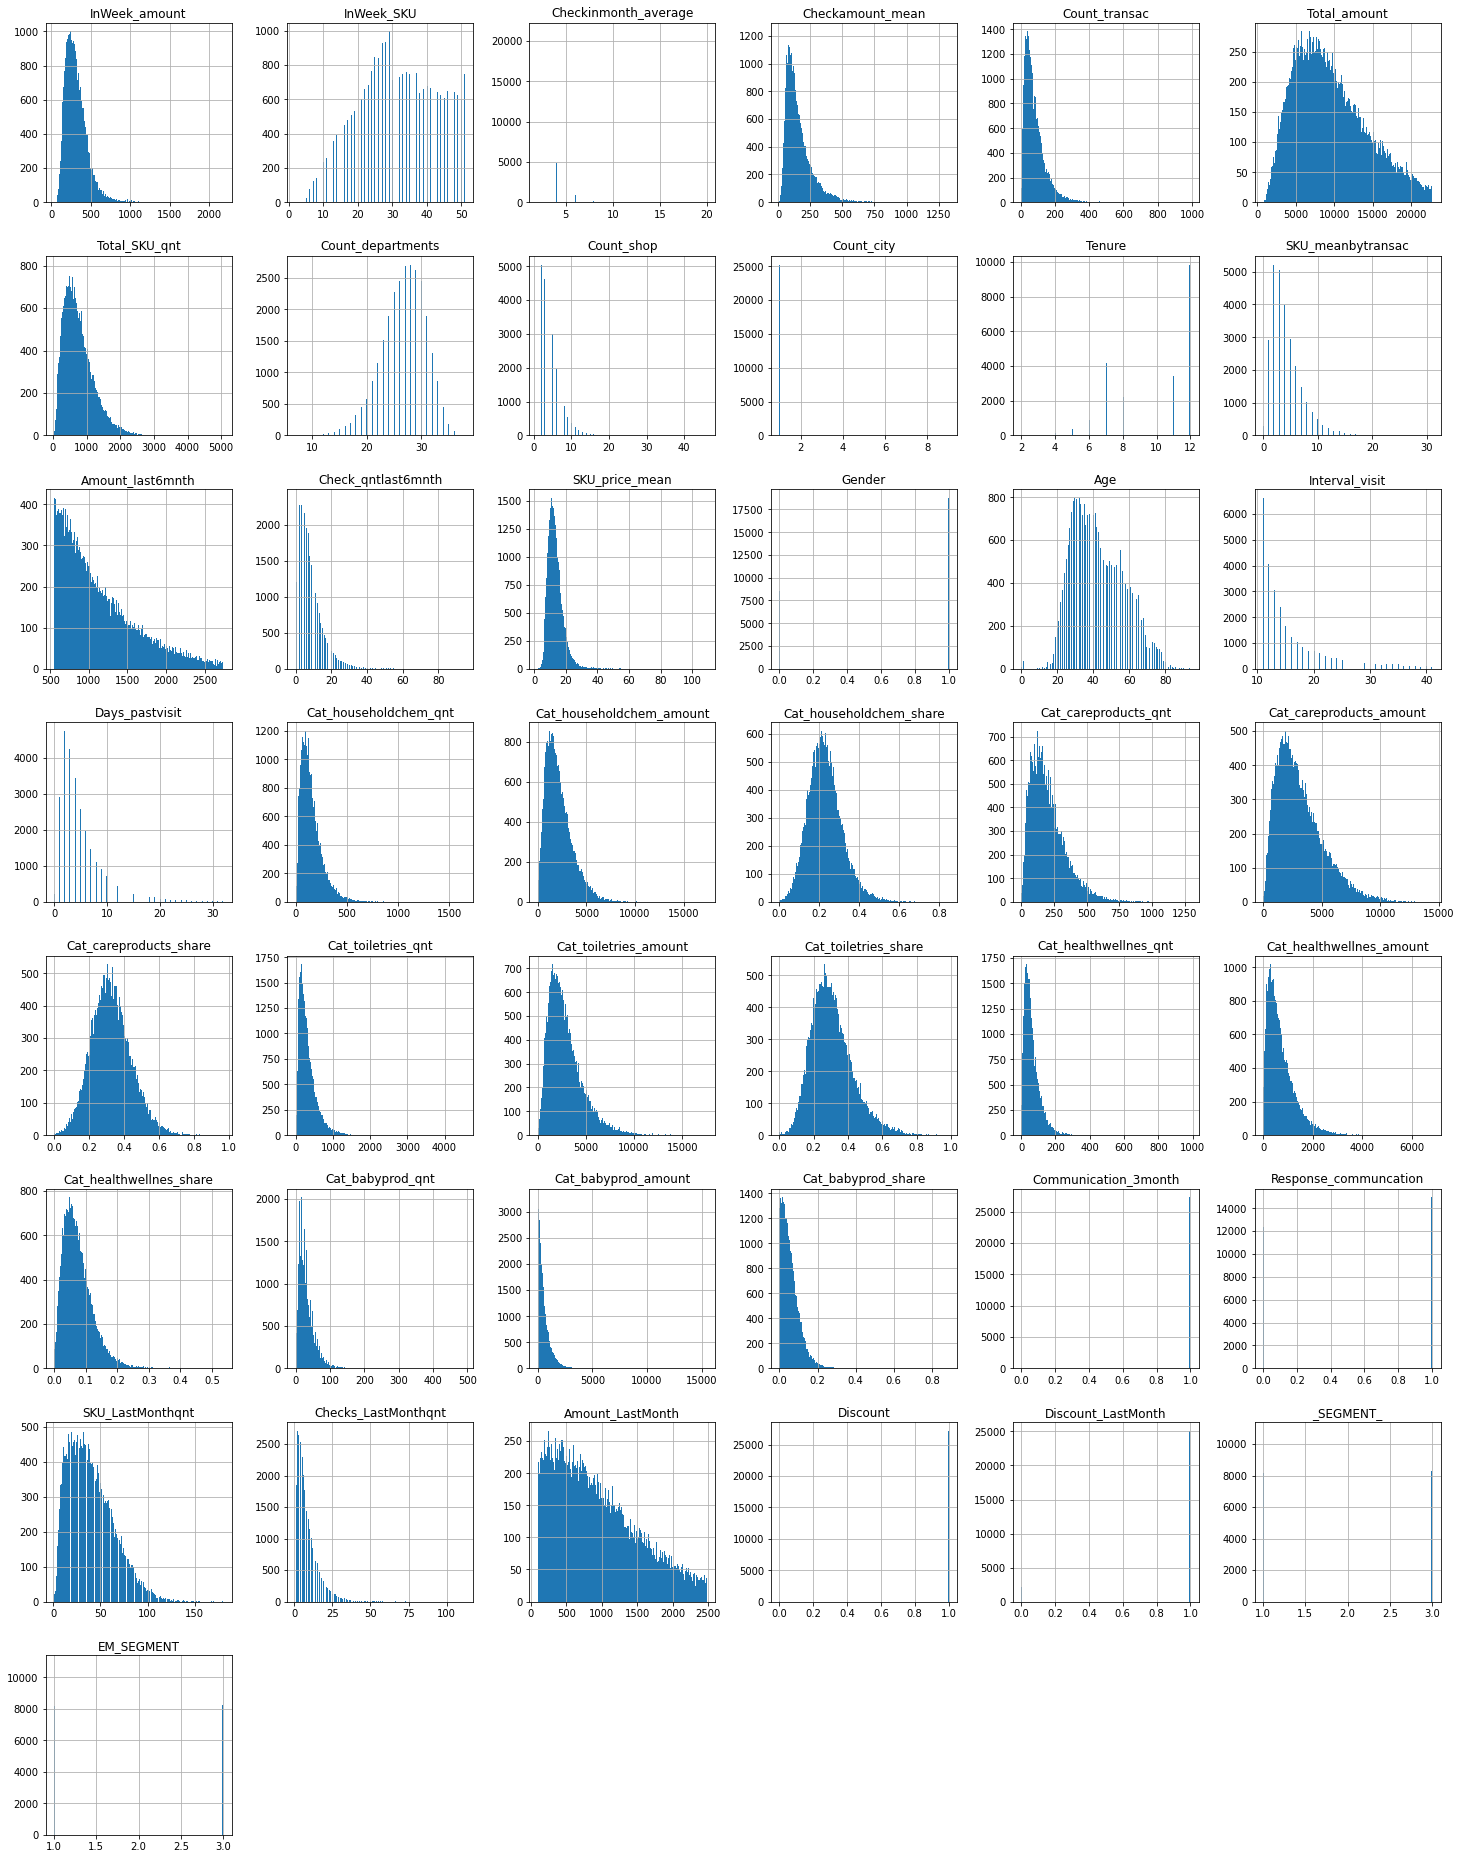

In [11]:
cols = 6
rows = df.shape[1] // cols + 1

figsize_x = 25
figsize_y = figsize_x/cols*rows

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
df.hist(ax=ax, layout=(rows,cols), bins=200)
plt.show()

Распределения величин в большинстве колонок - колоколообразное.

Корректируем асимметрию распределения, если она есть.

Нормировкой и смещением среднего приведем распределения к виду стандартного нормального распределения.

Нормировка необходима для того, чтобы при дальнейшем анализе не сказывался разный масштаб параметров.

In [12]:
skewed = df.columns[abs(df.skew())>1]
for col in skewed:
    if abs(df[col].skew()) > abs(np.log1p(df[col]).skew()):
        df[col] = np.log1p(df[col])
        
del skewed

In [13]:
for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()

In [14]:
df.describe()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04
mean,-8.824699e-14,3.110685e-15,9.282466e-13,1.025818e-14,1.347906e-13,-6.004716e-15,-1.190003e-15,-2.138599e-14,6.601889e-13,1.405675e-12,-1.399717e-13,4.811961e-13,-7.982937e-14,3.370049e-13,7.890421e-14,-2.015193e-15,2.073581e-16,2.132378e-12,4.563394e-13,-3.243730e-14,2.625380e-14,-4.274532e-15,4.794505e-14,-1.938293e-14,1.818140e-15,5.683966e-14,2.581582e-14,1.862893e-14,1.888192e-13,2.774227e-14,3.421699e-15,3.855904e-13,1.360520e-15,-6.436663e-15,2.039889e-15,-3.547775e-14,4.622855e-16,4.229455e-13,-5.102201e-15,2.925212e-12,2.989673e-14,1.498376e-15,1.498376e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.898702e+00,-2.586893e+00,-5.062273e-01,-4.029274e+00,-3.495287e+00,-1.877044e+00,-4.639683e+00,-4.889752e+00,-1.458256e+00,-2.782281e-01,-3.708634e+00,-2.923440e+00,-1.595137e+00,-2.429832e+00,-4.694760e+00,-1.487647e+00,-3.014692e+00,-9.402891e-01,-2.630564e+00,-5.524187e+00,-7.392819e+00,-2.659550e+00,-6.877700e+00,-1.082293e+01,-2.854971e+00,-6.774802e+00,-1.145569e+01,-2.499089e+00,-4.838431e+00,-6.741801e+00,-1.651777e+00,-4.070073e+00,-4.762238e+00,-1.255216e+00,-1.651212e+02,-1.100143e+00,-1.656630e+00,-1.836159e+00,-1.418353e+00,-2.265950e+01,-3.414432e+00,-1.293296e+00,-1.293296e+00
25%,-6.944638e-01,-7.409755e-01,-5.062273e-01,-6.898182e-01,-6.528232e-01,-7.844287e-01,-6.162370e-01,-6.784880e-01,-6.712276e-01,-2.782281e-01,-8.809718e-01,-8.124630e-01,-8.322205e-01,-6.715706e-01,-6.739713e-01,-1.487647e+00,-7.722580e-01,-6.836179e-01,-8.660667e-01,-6.019088e-01,-5.835471e-01,-6.827071e-01,-5.855867e-01,-5.822966e-01,-6.857932e-01,-6.186759e-01,-5.987846e-01,-7.035353e-01,-5.809967e-01,-5.658379e-01,-7.284248e-01,-6.119297e-01,-5.338920e-01,-7.519183e-01,6.055937e-03,-1.100143e+00,-7.726832e-01,-8.553046e-01,-8.278990e-01,4.412999e-02,2.928637e-01,-1.293296e+00,-1.293296e+00
50%,1.822942e-02,-3.776895e-02,-5.062273e-01,-3.488964e-02,5.226039e-02,-1.648642e-01,8.777612e-02,6.467631e-02,-1.128219e-01,-2.782281e-01,6.158213e-02,1.690852e-01,-1.109630e-01,3.819988e-02,-1.880720e-02,6.721778e-01,-1.415733e-01,-4.459776e-01,-4.562198e-02,8.334402e-02,1.026499e-01,-7.994007e-02,1.137860e-01,1.115893e-01,-6.281409e-02,6.895777

#### Взаимная корреляция столбцов:

Бывает полезно посмотреть на корреляционную матрицу

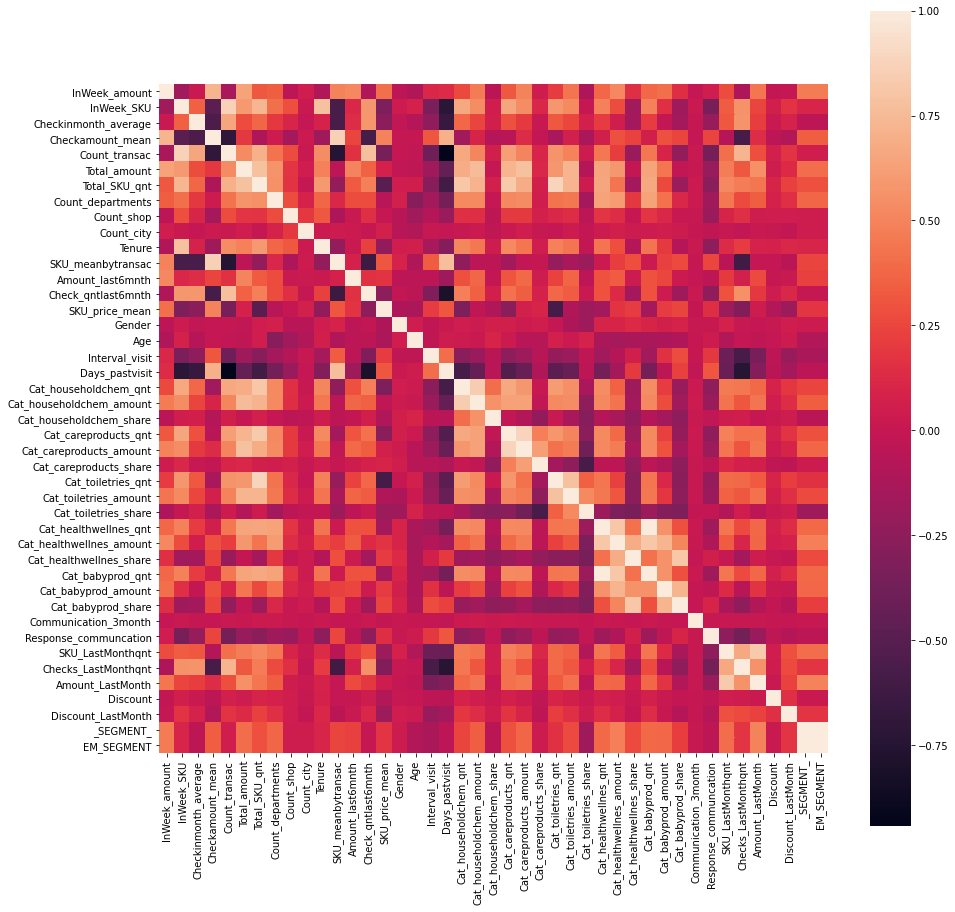

In [15]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, square=True)

Отдельное внимание уделим колонкам которые хорошо (>0.9) коррелируют друг с другом.

От них можно избавиться без критичной потери информации.

Index(['Count_transac', 'Days_pastvisit', 'Cat_healthwellnes_qnt',
       'Cat_babyprod_qnt', '_SEGMENT_', 'EM_SEGMENT'],
      dtype='object')


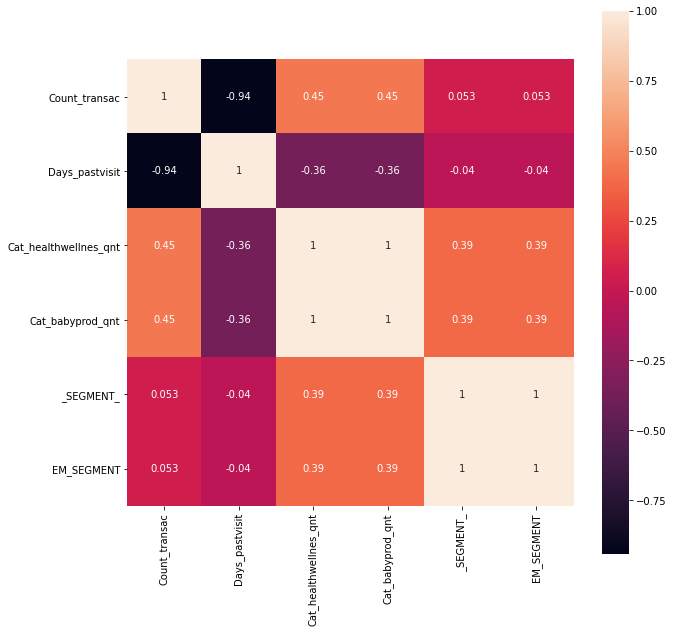

In [16]:
features = df.columns[(corrmat.abs()>0.9).sum()>1]
corrmat_f = df[features].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat_f, square=True, annot=True)

print(features)

Удаляем сильно скоррелированные колонки

In [17]:
df.drop(columns=[
    'EM_SEGMENT',
    'Cat_babyprod_qnt',
], inplace=True)

df.shape

(27267, 41)

### Кластеризация

Кластеризация в многомерном пространстве представляет собой чрезвычайно сложную задачу (Curse of dimensionality).

Попытаемся понизить размерность задачи.

В данных очевидно есть линейно зависимые колонки.

Например, из 'Total_amount' и 'Count_transac'  можно получить 'Checkamount_mean', делая использование последней не очень полезным.

Для того чтобы избавиться от подобных неинформативных колонок, попробуем преобразовать строки таблицы в эмбединги меньшей размерности.

Для создания эмбедингов воспользуемся автоэнкодером.

Напишем простой автоэнкодер который попытается снизить размерность с 41 до 28.

#### AutoEncoder

In [18]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, shape):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Linear(shape, shape-5),
            nn.ReLU(),
            nn.Linear(shape-5, shape-10),
            nn.ReLU(),
            nn.Linear(shape-10, shape-15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(shape-15, shape-10),
            nn.ReLU(),
            nn.Linear(shape-10, shape-5),
            nn.ReLU(),
            nn.Linear(shape-5, shape),

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate, 
                                weight_decay=1e-5) # <--

    outputs = []
    for epoch in range(num_epochs):
        permutation = torch.randperm(train_data.size()[0])
        for i in range(0,train_data.size()[0], batch_size):
        # for i in range(train_data.shape[0]):
            indices = permutation[i:i+batch_size]
            batch = train_data[indices]

            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            outputs.append(loss)
        if epoch % 10 == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    return outputs

In [19]:
train_data = df[:]
train_data = train_data.values
train_data = torch.tensor(train_data).to(torch.float)

model = Autoencoder(train_data.size()[1])

Epoch:1, Loss:0.3518
Epoch:11, Loss:0.0778
Epoch:21, Loss:0.0480
Epoch:31, Loss:0.0401
Epoch:41, Loss:0.0418
Epoch:51, Loss:0.0469
Epoch:61, Loss:0.0379
Epoch:71, Loss:0.0295
Epoch:81, Loss:0.0377
Epoch:91, Loss:0.0388
Epoch:101, Loss:0.0328
Epoch:111, Loss:0.0333
Epoch:121, Loss:0.0306
Epoch:131, Loss:0.0335
Epoch:141, Loss:0.0299
Epoch:151, Loss:0.0391
Epoch:161, Loss:0.0229
Epoch:171, Loss:0.0262
Epoch:181, Loss:0.0285
Epoch:191, Loss:0.0265
Epoch:201, Loss:0.0246
Epoch:211, Loss:0.0221
Epoch:221, Loss:0.0264
Epoch:231, Loss:0.0200
Epoch:241, Loss:0.0297
Epoch:251, Loss:0.0224
Epoch:261, Loss:0.0163
Epoch:271, Loss:0.0185
Epoch:281, Loss:0.0185
Epoch:291, Loss:0.0211
Epoch:301, Loss:0.0167
Epoch:311, Loss:0.0182
Epoch:321, Loss:0.0206
Epoch:331, Loss:0.0203
Epoch:341, Loss:0.0237
Epoch:351, Loss:0.0141
Epoch:361, Loss:0.0124
Epoch:371, Loss:0.0148
Epoch:381, Loss:0.0136
Epoch:391, Loss:0.0147


Text(0.5, 1.0, "Autoencoder's loss")

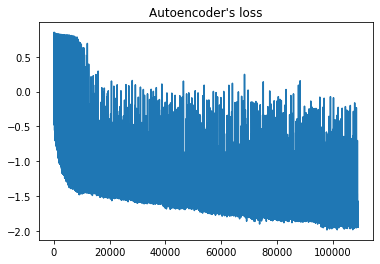

In [20]:
max_epochs = 200
outputs = train(model, num_epochs=max_epochs, batch_size=100)

fig, ax = plt.subplots()
ax.plot(np.log10(outputs))
ax.set_title("Autoencoder's loss")

Проверяем на нескольких примерах, что наш автоэнкодер выдает что-то вменяемое

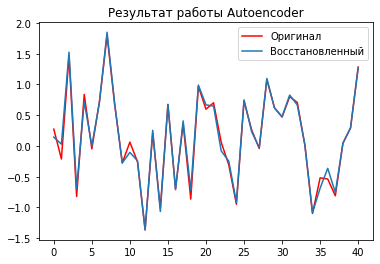

In [178]:
i = 7

fig, ax = plt.subplots()
ax.plot(df.values[i], c='r', label='Оригинал')
ax.plot(model(torch.tensor(df.loc[i].values).to(torch.float)).detach().numpy(), label='Восстановленный')
ax.set_title('Результат работы Autoencoder')
plt.legend()

In [22]:
data_encoded = model.encoder(torch.tensor(df.values).to(torch.float))
data_encoded = data_encoded.detach().numpy()
data_encoded.shape

(27267, 26)

#### t-SNE


Размерность понизили, но 28 всё еще много чтоб напрямую кластеризовать.

Эффективнее будет воспользоваться алгоритмом t-SNE, который с помощью нелинейного преобразования проецирует данные на пространство меньшей размерности, пытаясь сохранить расстояние между ними.

In [23]:
%%time
from sklearn.manifold import TSNE
X = data_encoded
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(data_encoded)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27267 samples in 0.127s...
[t-SNE] Computed neighbors for 27267 samples in 113.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27267
[t-SNE] Computed conditional probabilities for sample 2000 / 27267
[t-SNE] Computed conditional probabilities for sample 3000 / 27267
[t-SNE] Computed conditional probabilities for sample 4000 / 27267
[t-SNE] Computed conditional probabilities for sample 5000 / 27267
[t-SNE] Computed conditional probabilities for sample 6000 / 27267
[t-SNE] Computed conditional probabilities for sample 7000 / 27267
[t-SNE] Computed conditional probabilities for sample 8000 / 27267
[t-SNE] Computed conditional probabilities for sample 9000 / 27267
[t-SNE] Computed conditional probabilities for sample 10000 / 27267
[t-SNE] Computed conditional probabilities for sample 11000 / 27267
[t-SNE] Computed conditional probabilities for sample 12000 / 27267
[t-SNE] Computed conditional probabilities for s

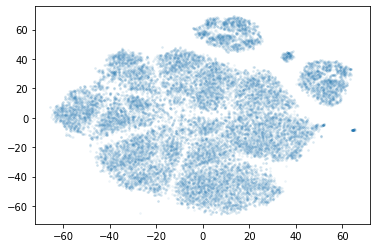

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=3, alpha=0.05)

Визуально похоже на то, что какие-то кластеры в данных нашлись.

Пробуем выделить их алгоритмом кластеризации DBSCAN.

#### **DBSCAN**

DBSCAN хорош тем, что не требует предварительного задания числа кластеров и умеет находить кластеры со сложной топологией

In [135]:
clustering = DBSCAN(eps=5, min_samples=200).fit(X_embedded)
labels = clustering.labels_
del clustering
# del X
n_clusters_ = len(set(labels))
print(n_clusters_)
print(set(labels))

5
{0, 1, 2, 3, -1}


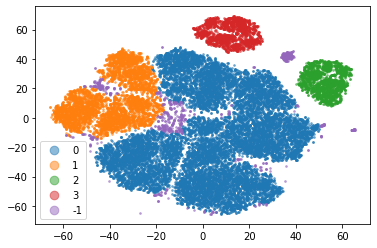

In [136]:
fig, ax = plt.subplots()
for label in set(labels):
    mask = labels==label
    ax.scatter(X_embedded[mask][:,0], X_embedded[mask][:,1], s=3, alpha=0.5, label=label)

plt.legend(markerscale=5)
plt.show()

Отлично, получили кластеры

В зависимости от задачи - можно делить данные на более мелкие кластеры, но пока пройдемся широкими мазками

4 кластера вполне достаточно.

### Анализ получившихся кластеров

Попытаемся понять какие парамеры стали ключевыми при кластеризации, и как кластеры можно трактовать

In [137]:
sub_df_raw = df_raw.copy()
sub_df = df.copy()

Добавляем метки кластеров к нормализованным и оригинальным данным.

Избавляемся строк, которые не попали ни в один из кластеров.

In [138]:
sub_df['labels'] = labels
sub_df_raw['labels'] = labels

sub_df = sub_df.drop(sub_df[sub_df['labels'] == -1].index)
sub_df_raw = sub_df_raw.drop(sub_df_raw[sub_df_raw['labels'] == -1].index)

sub_df_raw['labels'].value_counts()

0    17535
1     5090
2     1919
3     1848
Name: labels, dtype: int64

Ищем колонки в которых средние значения отличаются для разных кластеров

In [176]:
std_of_mean = sub_df.groupby(by='labels').mean().std().sort_values(ascending=False)
columns = std_of_mean[:15].index

std_of_mean.head(15)

Count_city               1.865861
Discount_LastMonth       1.852682
Checkinmonth_average     1.039539
Checks_LastMonthqnt      0.842250
Count_transac            0.793229
Days_pastvisit           0.785362
SKU_LastMonthqnt         0.690931
Check_qntlast6mnth       0.665362
SKU_meanbytransac        0.616406
Checkamount_mean         0.613821
Total_SKU_qnt            0.608668
Cat_householdchem_qnt    0.565770
Cat_toiletries_qnt       0.555912
InWeek_SKU               0.539813
Amount_LastMonth         0.536147
dtype: float64

Cмотрим, на отличия в распределении данных для различных кластеров

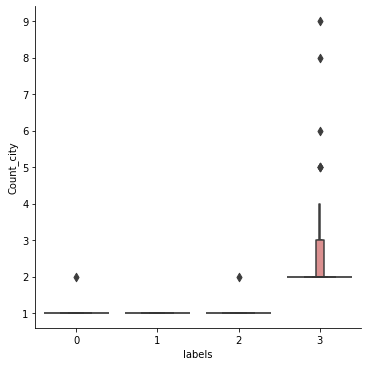

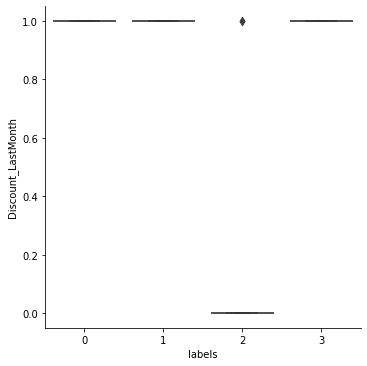

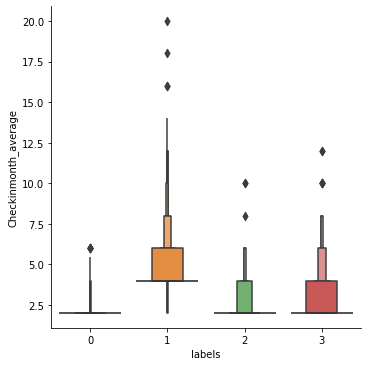

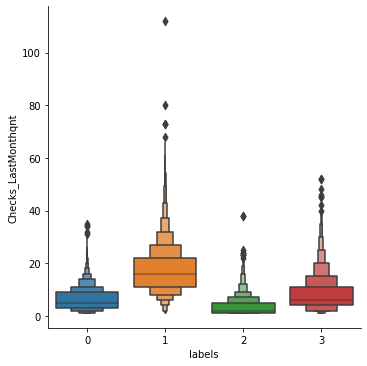

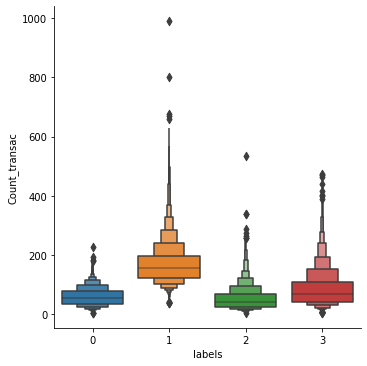

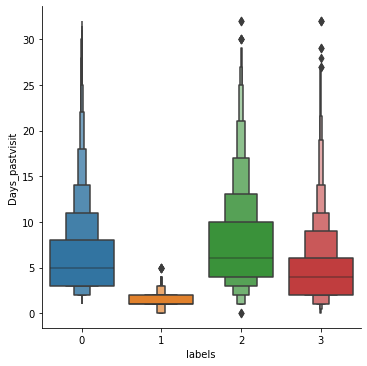

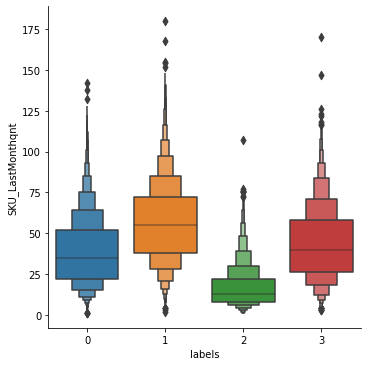

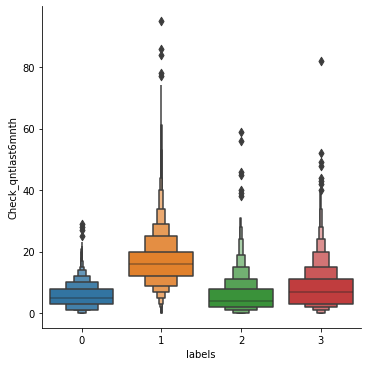

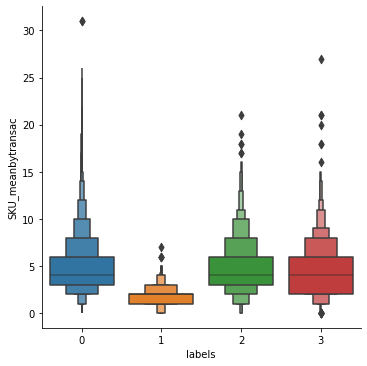

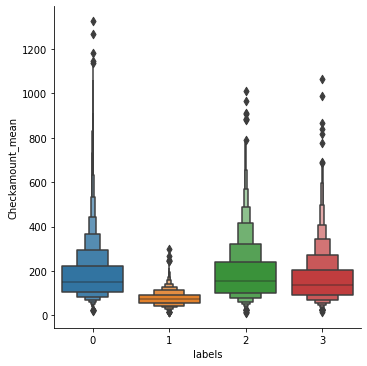

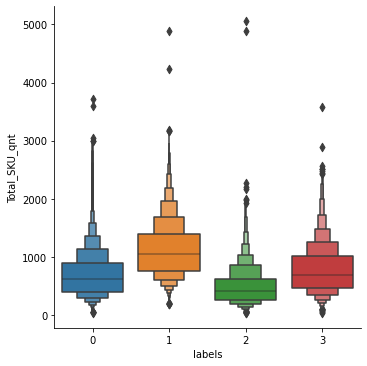

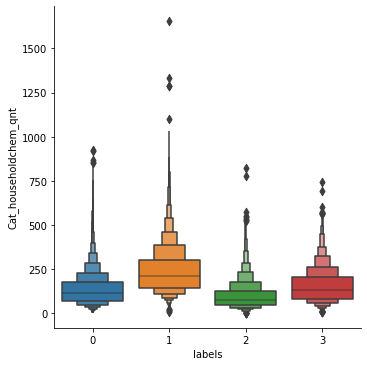

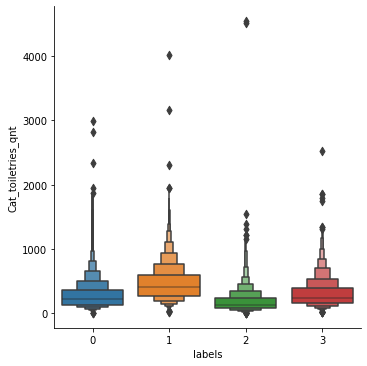

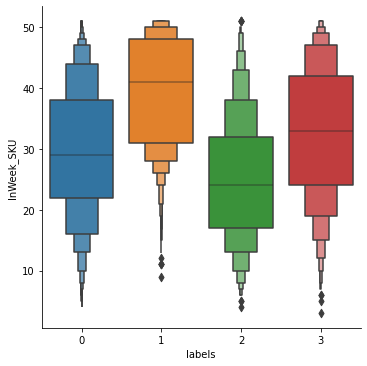

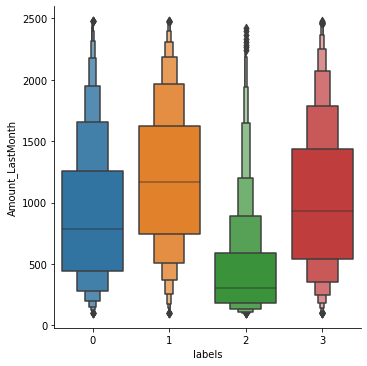

In [175]:
for col in columns:
    g = sns.catplot(x='labels', y=col, data=sub_df_raw, kind="boxen")
# plt.show()

Пытаясь угадать по их названию колонок, что за информация в них лежит, можно как-то интерпретировать полученный результат:

 - Например, в кластере #2 - малое количество чеков за прошлый месяц (Checks_LastMonthqnt), большое число дней со времени прошлого визита('Days_pastvisit'), но типичная сумма чека ('Checkamount_mean') не сильно отличается от средней. Можно предположить, что в этот кластер попали клиенты, которые в последнее время стали меньше пользоваться услугами компании.
 - В кластере #1 большое число чеков за последнее время ('Check_qntlast6mnth'), малое время с момента последнего визита ('Days_pastvisit'). Этот кластер похож на активных постоянных клиентов.
 - Кластеры #0 и #3 очень похожи друг на друга по большинству параметров, кроме параметра 'Count_city'. Возможно это паразитный эффект и кластеры не стоило делить между собой. Можно было бы исключить колонку "Count_city" из анализа, но для этого нужно понимать какую информацию она в себе несет.

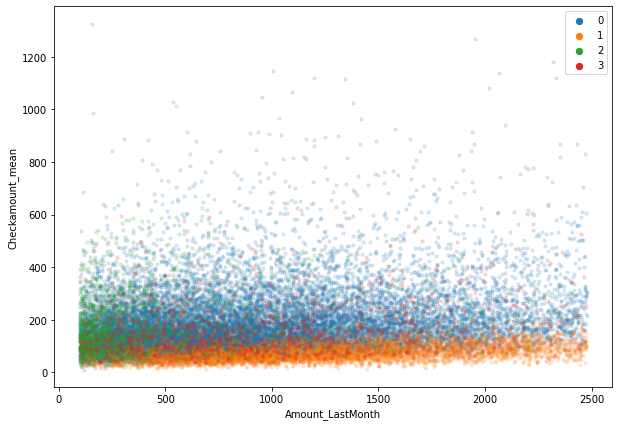

In [179]:
fig, ax = plt.subplots(figsize=(10,7))
col1 = 'Amount_LastMonth'
col2 = 'Checkamount_mean'
for label in sub_df_raw['labels'].unique():
    mask = sub_df_raw['labels']==label
    ax.scatter(sub_df_raw[mask][col1], sub_df_raw[mask][col2], s=10, alpha=0.15,label=label)

ax.set_xlabel(col1)
ax.set_ylabel(col2)
leg = plt.legend(markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()

Можно строить подобные картинки.

Здесь, например, наглядно видно, что оранжевый кластер №1 соответствует малым значениям в колонке "Checkamount_mean" , а зеленый кластер №2 - малым значениям в колонке "Amount_LastMonth". Красный кластер №3 не имеет ярко выраженной структуры.

### Fin

Сделали модельку/пайплайн который может кластеризовать сложные многомерные данные о клиентах.

Полученные кластеры можно интерпретировать и отнести к различным сегментам клиентов.

Модель можно гибко подстраивать под различные задачи.